ANALYSIS

In [1]:
from numpy import sum
from pandas import DataFrame, Series, read_csv
from matplotlib.pyplot import figure, show
from dslabs_functions import HEIGHT, plot_line_chart
from matplotlib.pyplot import savefig

file_tag = "forecast-traffic"
filename = "datasets/forecast_traffic_single.csv"
index = "Timestamp"
target = "Total"
data: DataFrame = read_csv(
    filename,
    index_col=index,
    sep=",",
    parse_dates=True,
    infer_datetime_format=True,
)
series: Series = data[target]

Granularity

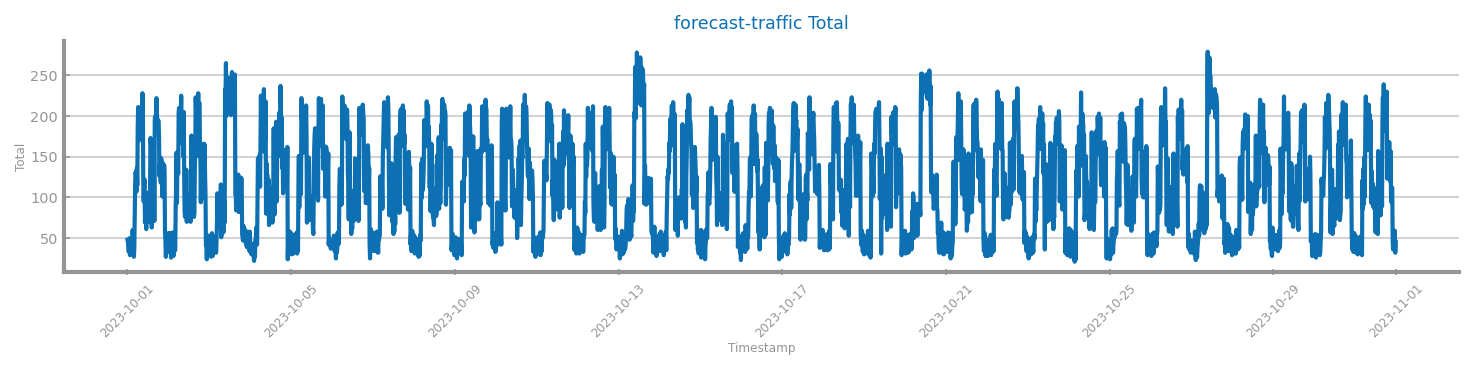

In [2]:
figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    series.index.to_list(),
    series.to_list(),
    xlabel=series.index.name,
    ylabel=target,
    title=f"{file_tag} {target}",
)

savefig(f"images/forecast/{file_tag}_granularity_total.png")
show()

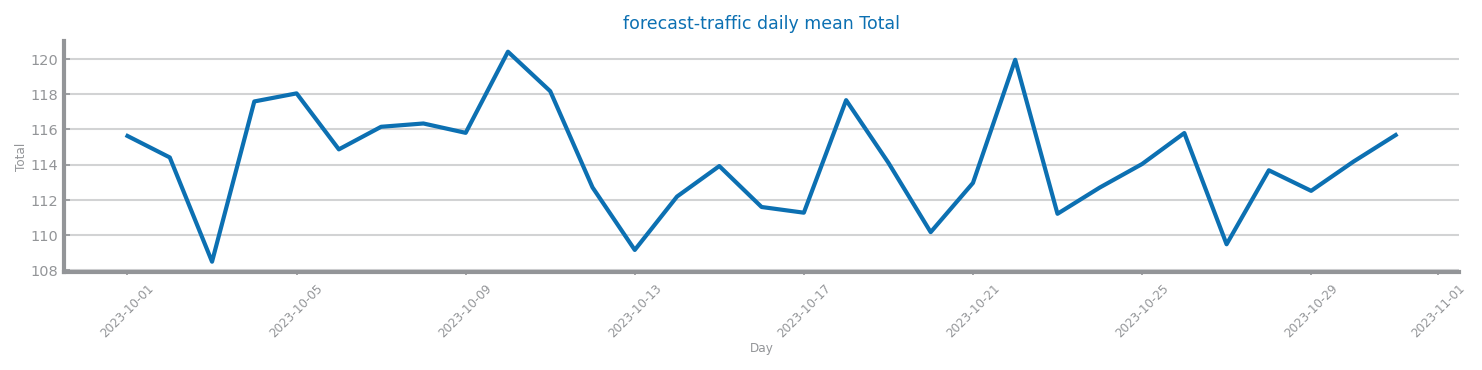

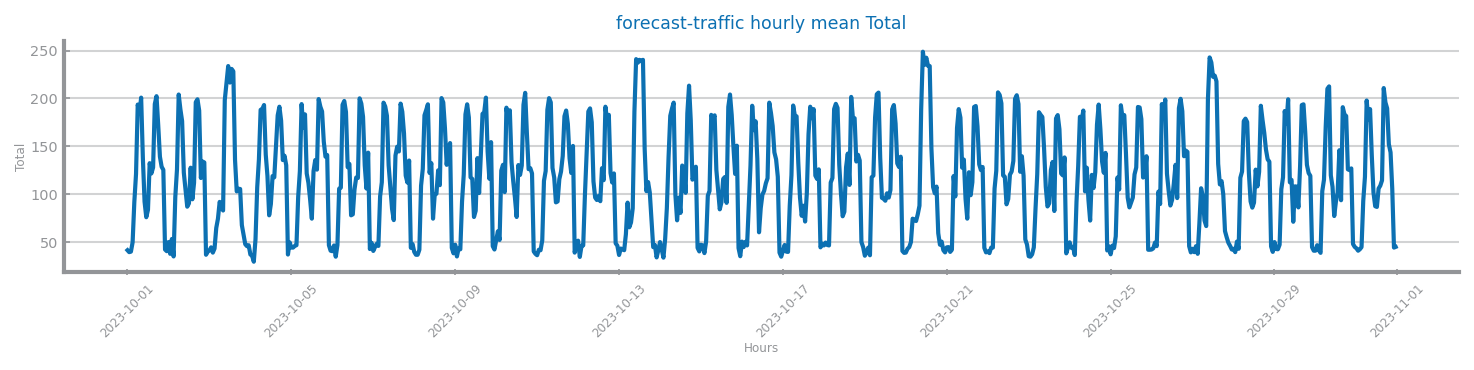

In [3]:
from pandas import Index, Period


def ts_aggregation_by(
    data: Series | DataFrame,
    gran_level: str = "D",
    agg_func: str = "mean",
) -> Series | DataFrame:
    df: Series | DataFrame = data.copy()
    index: Index[Period] = df.index.to_period(gran_level)
    df = df.groupby(by=index, dropna=True, sort=True).agg(agg_func)
    df.index.drop_duplicates()
    df.index = df.index.to_timestamp()

    return df


ss_days: Series = ts_aggregation_by(series, "D")
figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    ss_days.index.to_list(),
    ss_days.to_list(),
    xlabel="Day",
    ylabel=target,
    title=f"{file_tag} daily mean {target}",
)

savefig(f"images/forecast/{file_tag}_agg_daily_mean.png")
show()


ss_days: Series = ts_aggregation_by(series, "H")
figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    ss_days.index.to_list(),
    ss_days.to_list(),
    xlabel="Hours",
    ylabel=target,
    title=f"{file_tag} hourly mean {target}",
)
savefig(f"images/forecast/{file_tag}_agg_hourly_mean.png")
show()

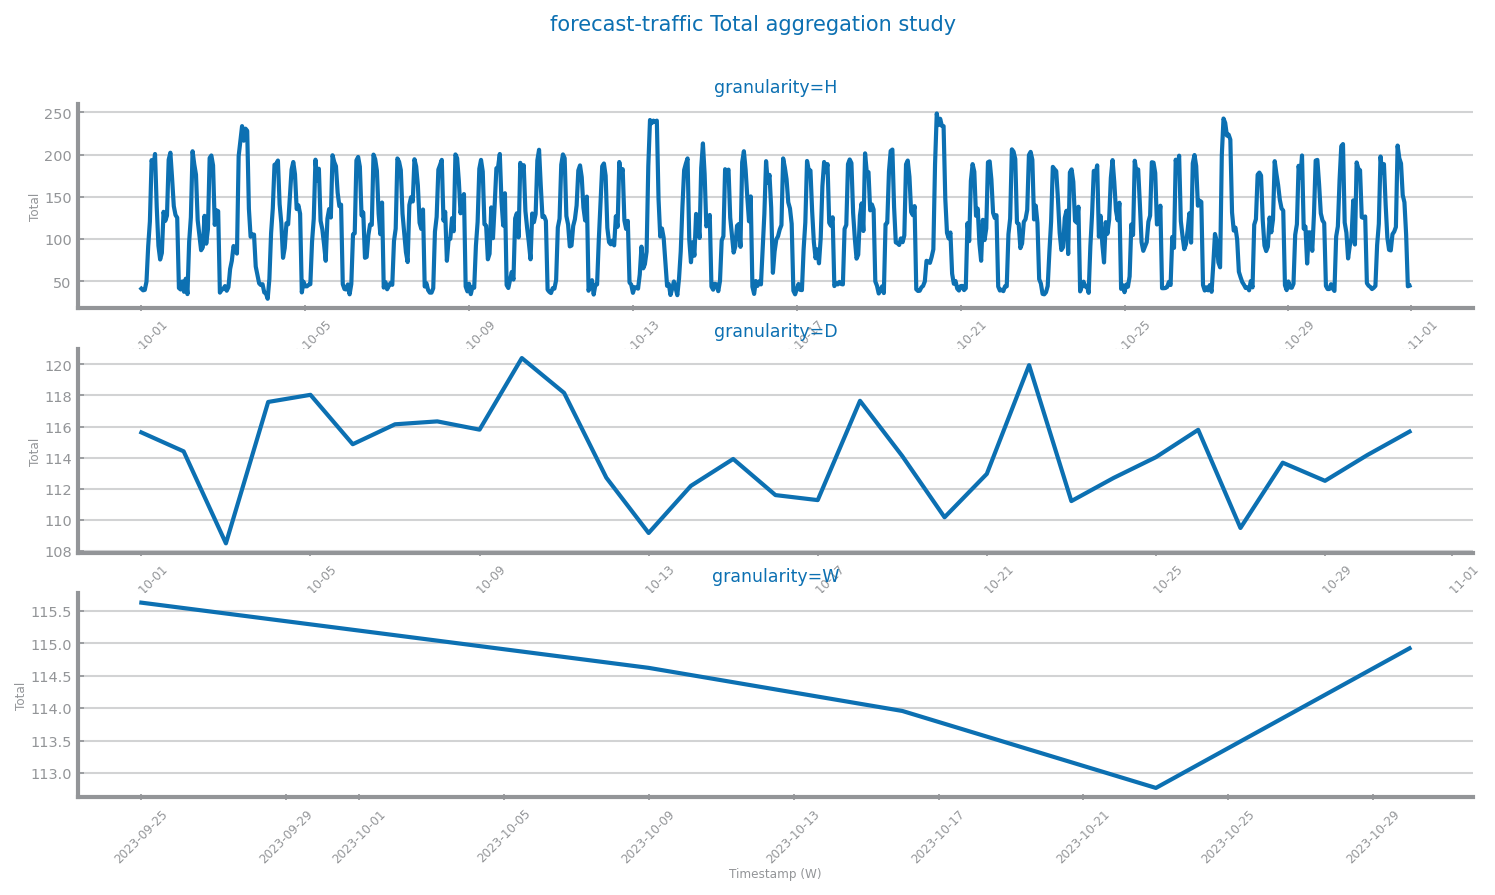

In [4]:
from matplotlib.pyplot import subplots
from matplotlib.axes import Axes
from matplotlib.figure import Figure


grans: list[str] = ["H", "D", "W"]
fig: Figure
axs: list[Axes]
fig, axs = subplots(len(grans), 1, figsize=(3 * HEIGHT, HEIGHT / 2 * len(grans)))
fig.suptitle(f"{file_tag} {target} aggregation study")

for i in range(len(grans)):
    ss: Series = ts_aggregation_by(series, grans[i])
    plot_line_chart(
        ss.index.to_list(),
        ss.to_list(),
        ax=axs[i],
        xlabel=f"{ss.index.name} ({grans[i]})",
        ylabel=target,
        title=f"granularity={grans[i]}",
    )

savefig(f"images/forecast/{file_tag}_agg_study_H_D_W.png")
show()

DISTRIBUITION

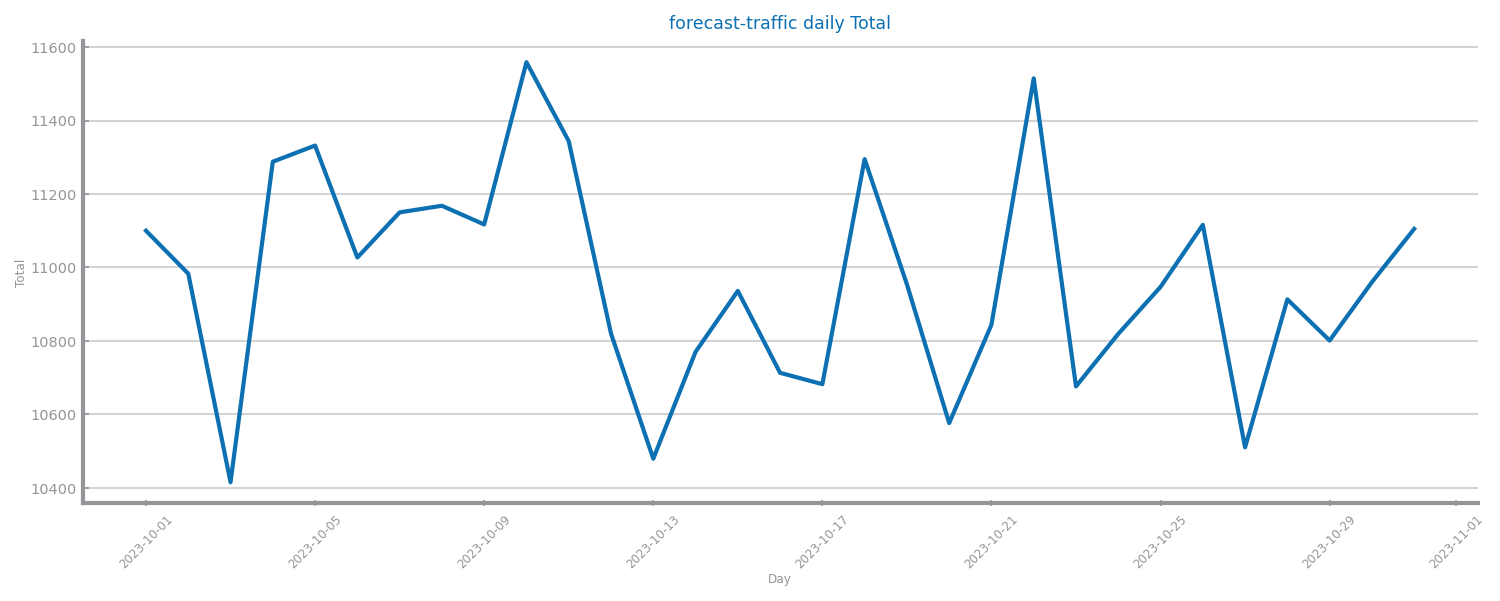

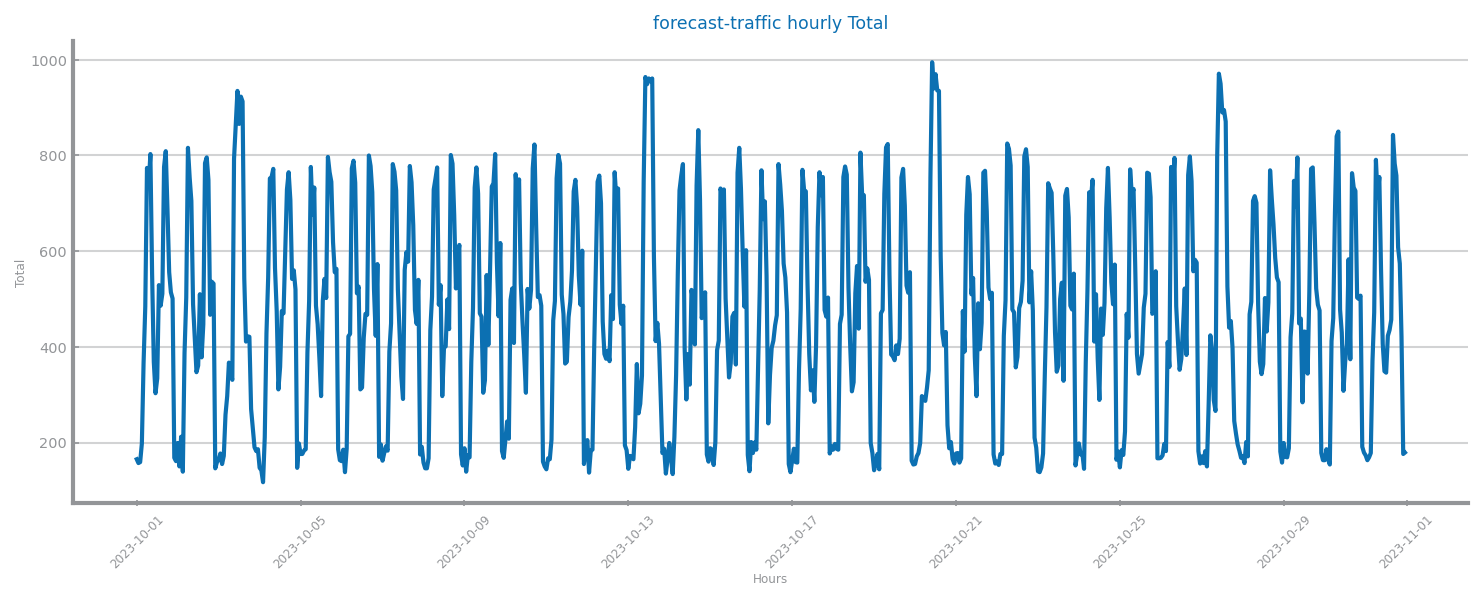

In [5]:
ss_days: Series = ts_aggregation_by(series, gran_level="D", agg_func=sum)

figure(figsize=(3 * HEIGHT, HEIGHT))
plot_line_chart(
    ss_days.index.to_list(),
    ss_days.to_list(),
    xlabel="Day",
    ylabel=target,
    title=f"{file_tag} daily {target}",
)

savefig(f"images/forecast/{file_tag}_agg_daily_sum.png")
show()

ss_hours: Series = ts_aggregation_by(series, gran_level="H", agg_func=sum)

figure(figsize=(3 * HEIGHT, HEIGHT))
plot_line_chart(
    ss_hours.index.to_list(),
    ss_hours.to_list(),
    xlabel="Hours",
    ylabel=target,
    title=f"{file_tag} hourly {target}",
)

savefig(f"images/forecast/{file_tag}_agg_hourly_sum.png")
show()

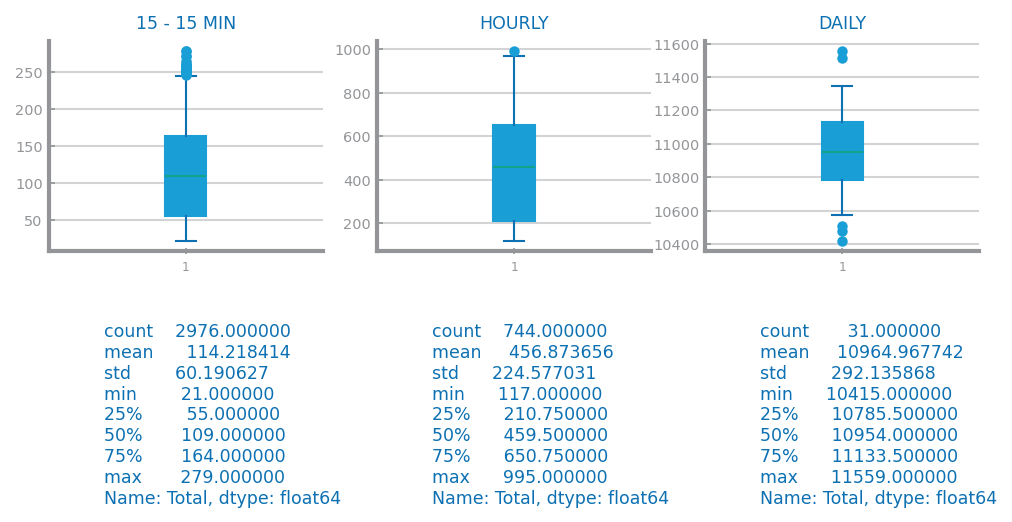

In [6]:
from numpy import array
from matplotlib.pyplot import show, subplots
from matplotlib.figure import Figure
from dslabs_functions import set_chart_labels

fig: Figure
axs: array
fig, axs = subplots(2, 3, figsize=(2 * HEIGHT, HEIGHT))
set_chart_labels(axs[0, 0], title="15 - 15 MIN")
axs[0, 0].boxplot(series)
set_chart_labels(axs[0, 1], title="HOURLY")
axs[0, 1].boxplot(ss_hours)
set_chart_labels(axs[0, 2], title="DAILY")
axs[0, 2].boxplot(ss_days)

axs[1, 0].grid(False)
axs[1, 0].set_axis_off()
axs[1, 0].text(0.2, 0, str(series.describe()), fontsize="small")

axs[1, 1].grid(False)
axs[1, 1].set_axis_off()
axs[1, 1].text(0.2, 0, str(ss_hours.describe()), fontsize="small")

axs[1, 2].grid(False)
axs[1, 2].set_axis_off()
axs[1, 2].text(0.2, 0, str(ss_days.describe()), fontsize="small")

savefig(f"images/forecast/{file_tag}_distribuition_boxplots.png")
show()

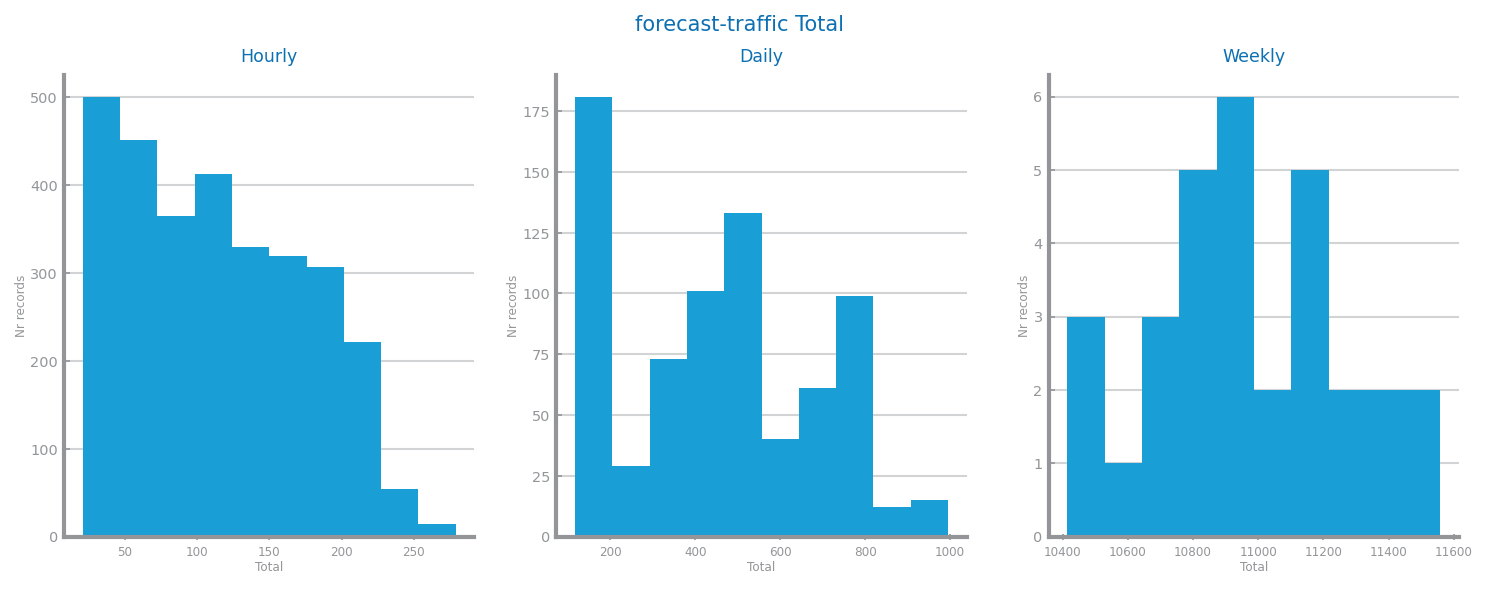

In [7]:
ss_days: Series = ts_aggregation_by(series, gran_level="D", agg_func=sum)

grans: list[Series] = [series, ss_hours, ss_days]
gran_names: list[str] = ["Hourly", "Daily", "Weekly"]
fig: Figure
axs: array
fig, axs = subplots(1, len(grans), figsize=(len(grans) * HEIGHT, HEIGHT))
fig.suptitle(f"{file_tag} {target}")
for i in range(len(grans)):
    set_chart_labels(axs[i], title=f"{gran_names[i]}", xlabel=target, ylabel="Nr records")
    axs[i].hist(grans[i].values)

savefig(f"images/forecast/{file_tag}_distribuition_histograms.png")
show()

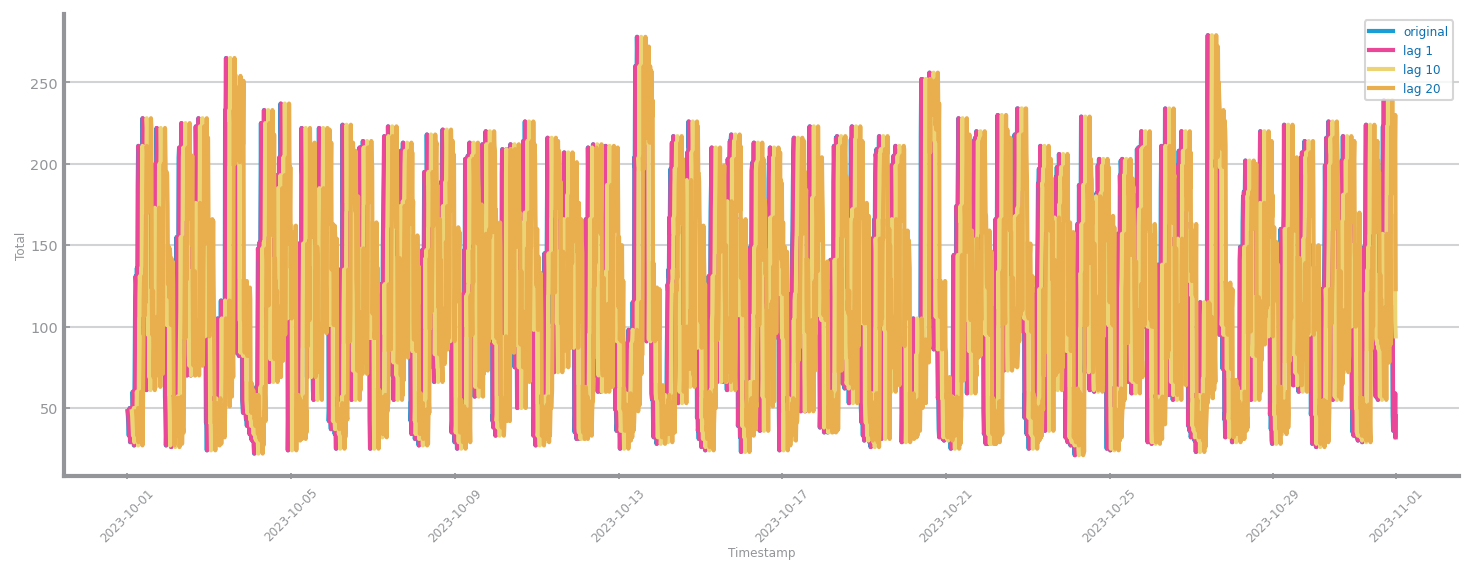

In [8]:
from dslabs_functions import plot_multiline_chart


def get_lagged_series(series: Series, max_lag: int, delta: int = 1):
    lagged_series: dict = {"original": series, "lag 1": series.shift(1)}
    for i in range(delta, max_lag + 1, delta):
        lagged_series[f"lag {i}"] = series.shift(i)
    return lagged_series


figure(figsize=(3 * HEIGHT, HEIGHT))
lags = get_lagged_series(series, 20, 10)
plot_multiline_chart(series.index.to_list(), lags, xlabel=index, ylabel=target)

savefig(f"images/forecast/{file_tag}_autocorrelation_lagged_plot.png")

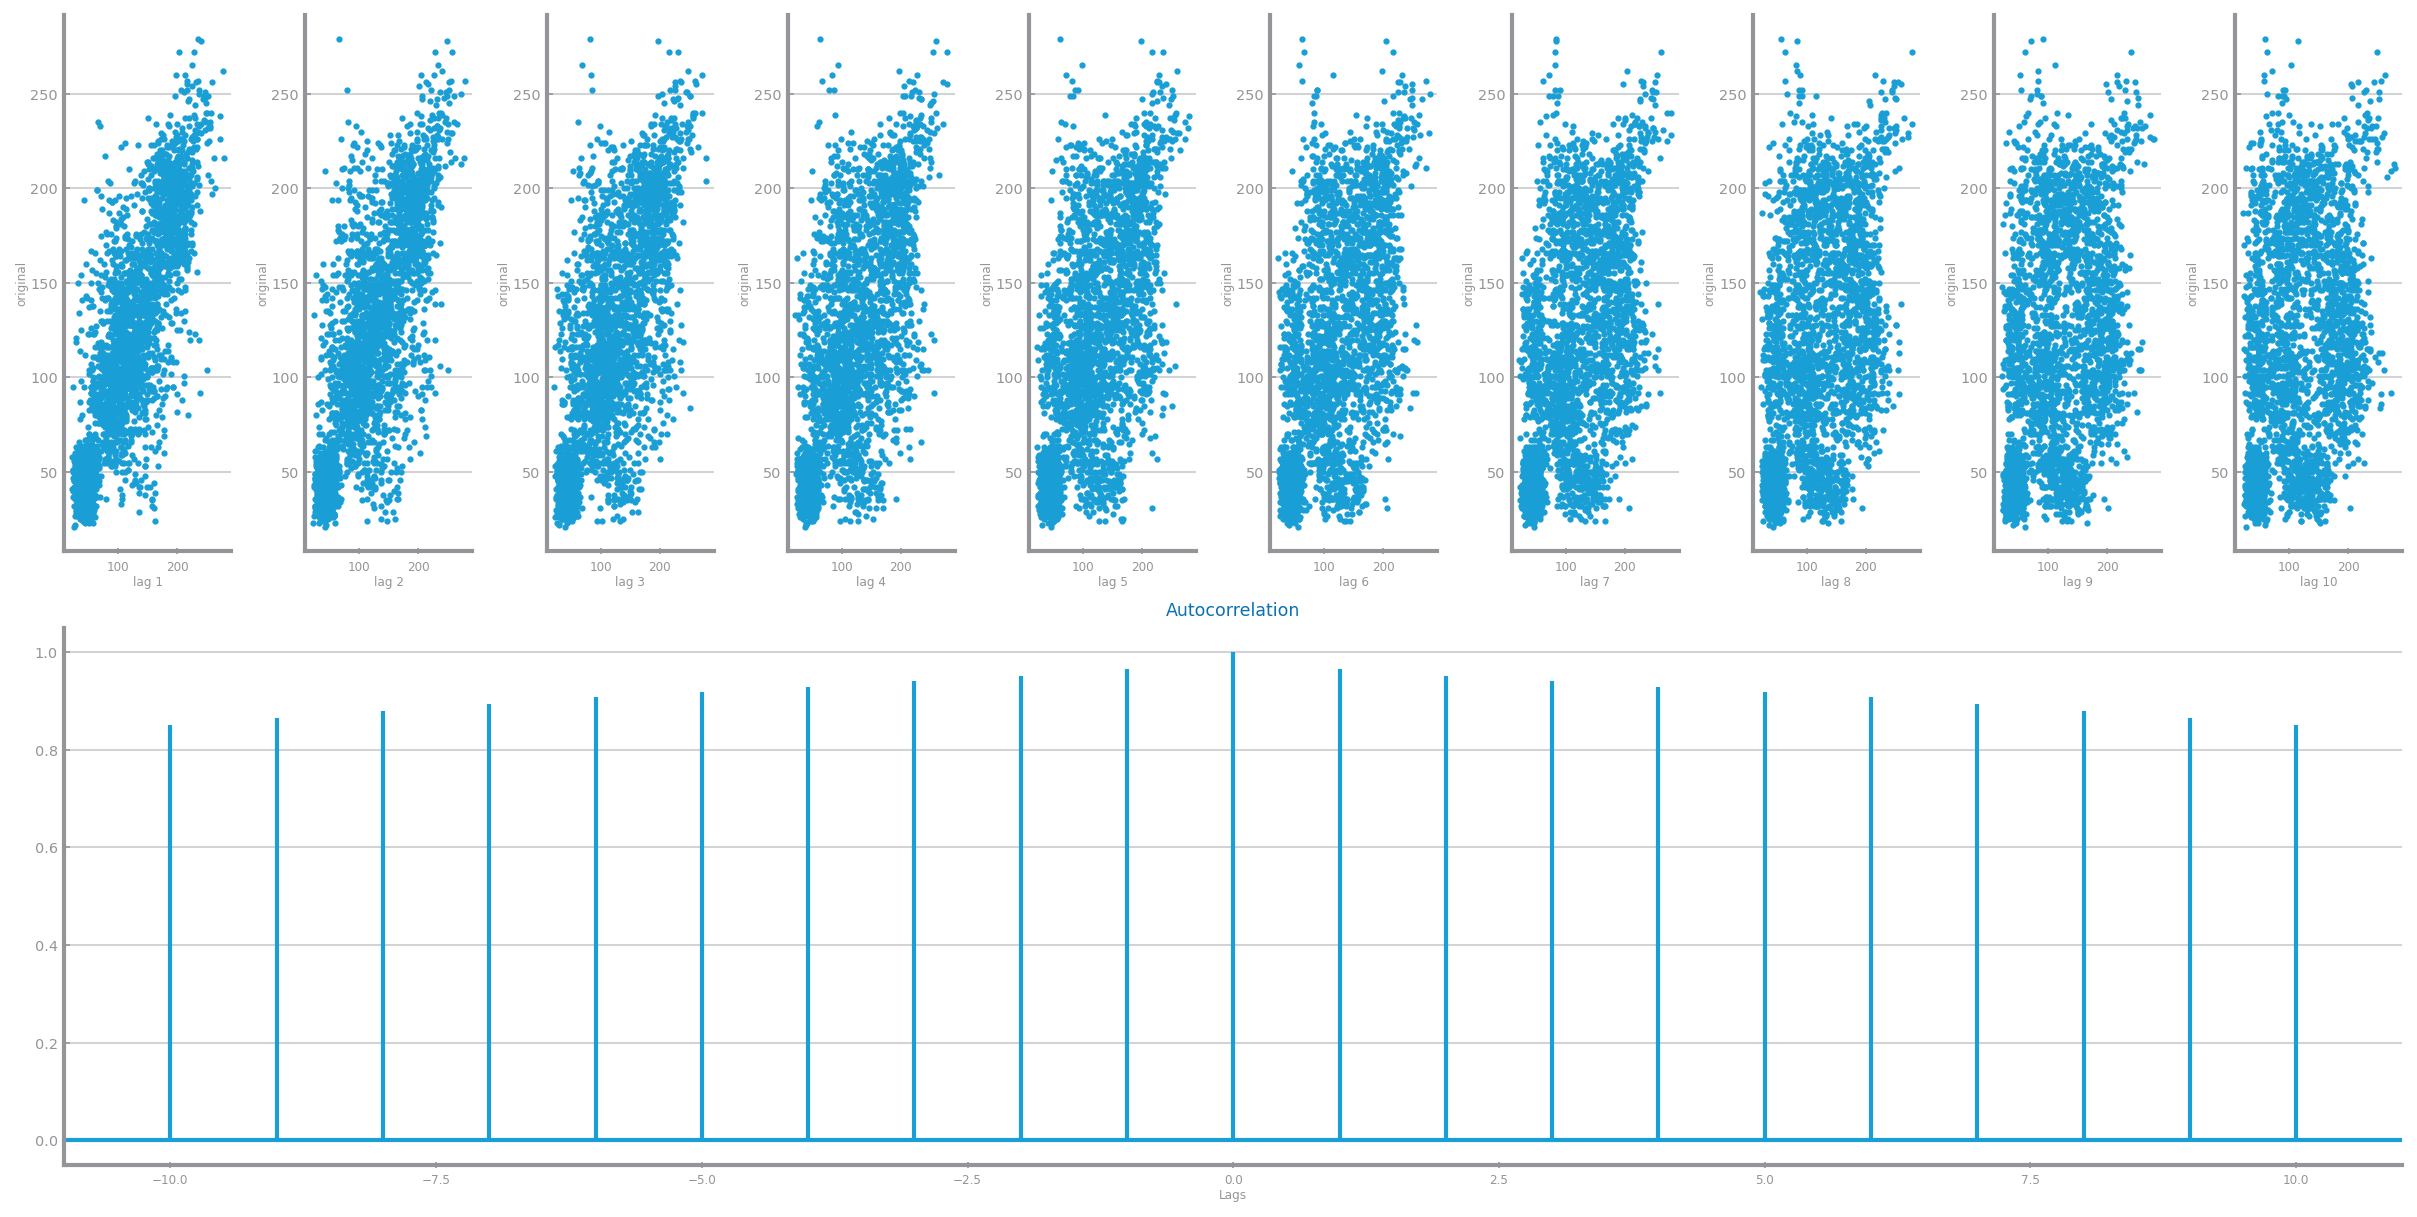

In [9]:
from matplotlib.pyplot import setp
from matplotlib.gridspec import GridSpec


def autocorrelation_study(series: Series, max_lag: int, delta: int = 1):
    k: int = int(max_lag / delta)
    fig = figure(figsize=(4 * HEIGHT, 2 * HEIGHT), constrained_layout=True)
    gs = GridSpec(2, k, figure=fig)

    series_values: list = series.tolist()
    for i in range(1, k + 1):
        ax = fig.add_subplot(gs[0, i - 1])
        lag = i * delta
        ax.scatter(series.shift(lag).tolist(), series_values)
        ax.set_xlabel(f"lag {lag}")
        ax.set_ylabel("original")
    ax = fig.add_subplot(gs[1, :])
    ax.acorr(series, maxlags=max_lag)
    ax.set_title("Autocorrelation")
    ax.set_xlabel("Lags")
    return


autocorrelation_study(series, 10, 1)

savefig(f"images/forecast/{file_tag}_autocorrelation_correlogram.png")

COMPONENT STUDY

In [10]:
from pandas import Series
from matplotlib.pyplot import subplots, show, gca
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from statsmodels.tsa.seasonal import DecomposeResult, seasonal_decompose
from dslabs_functions import HEIGHT, set_chart_labels


def plot_components(
    series: Series,
    title: str = "",
    x_label: str = "time",
    y_label: str = "",
) -> list[Axes]:
    decomposition: DecomposeResult = seasonal_decompose(series, model="add", period=96)
    components: dict = {
        "observed": series,
        "trend": decomposition.trend,
        "seasonal": decomposition.seasonal,
        "residual": decomposition.resid,
    }
    rows: int = len(components)
    fig: Figure
    axs: list[Axes]
    fig, axs = subplots(rows, 1, figsize=(3 * HEIGHT, rows * HEIGHT))
    fig.suptitle(f"{title}")
    i: int = 0
    for key in components:
        set_chart_labels(axs[i], title=key, xlabel=x_label, ylabel=y_label)
        axs[i].plot(components[key])
        i += 1
    return axs

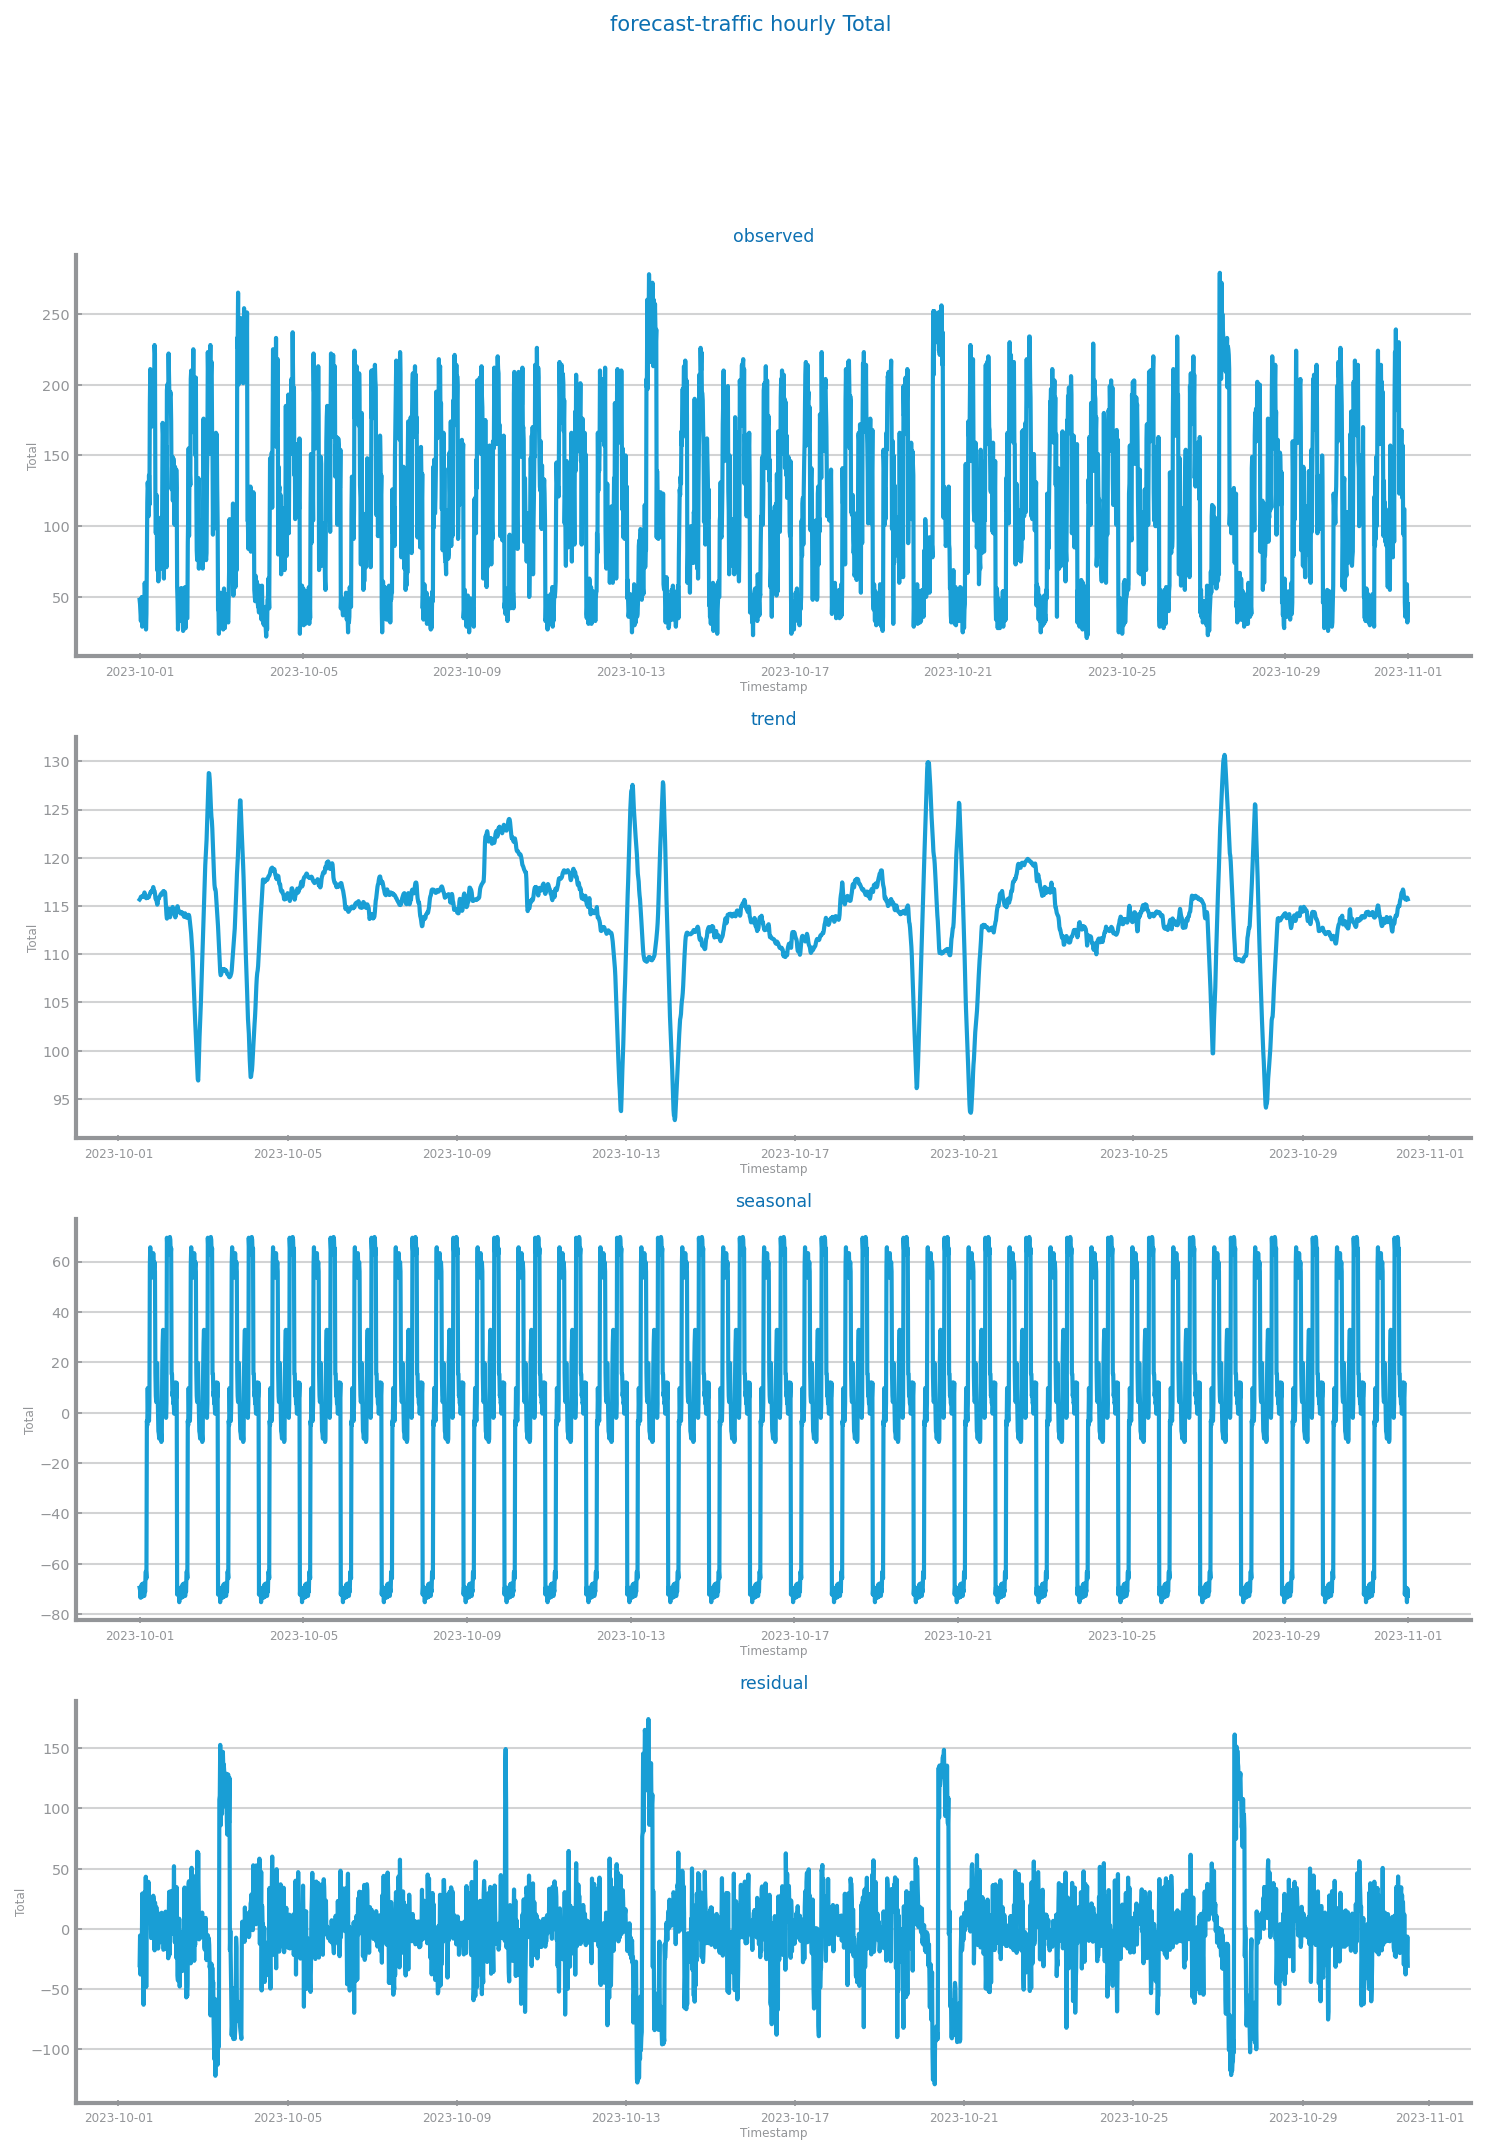

In [11]:
plot_components(
    series,
    title=f"{file_tag} hourly {target}",
    x_label=series.index.name,
    y_label=target,
)
savefig(f"images/forecast/{file_tag}_components.png")
show()

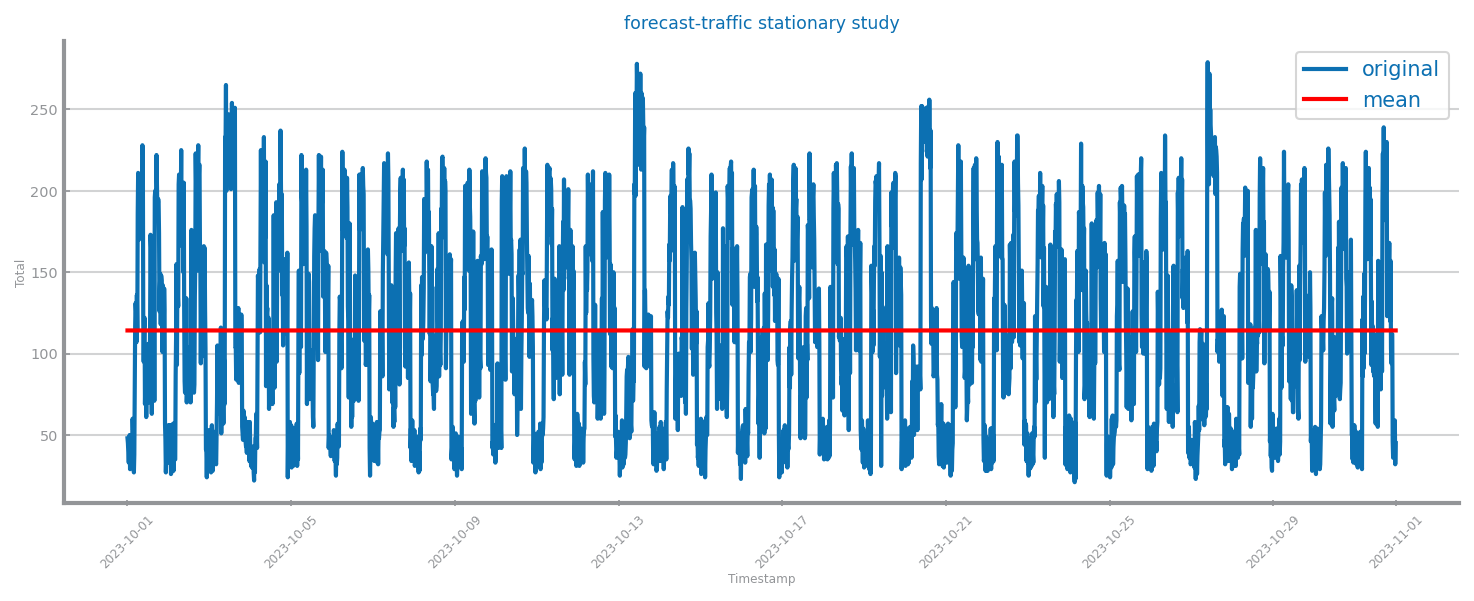

In [12]:
from matplotlib.pyplot import plot, legend

figure(figsize=(3 * HEIGHT, HEIGHT))
plot_line_chart(
    series.index.to_list(),
    series.to_list(),
    xlabel=series.index.name,
    ylabel=target,
    title=f"{file_tag} stationary study",
    name="original",
)
n: int = len(series)
plot(series.index, [series.mean()] * n, "r-", label="mean")
legend()

savefig(f"images/forecast/{file_tag}_stationarity_mean.png")
show()

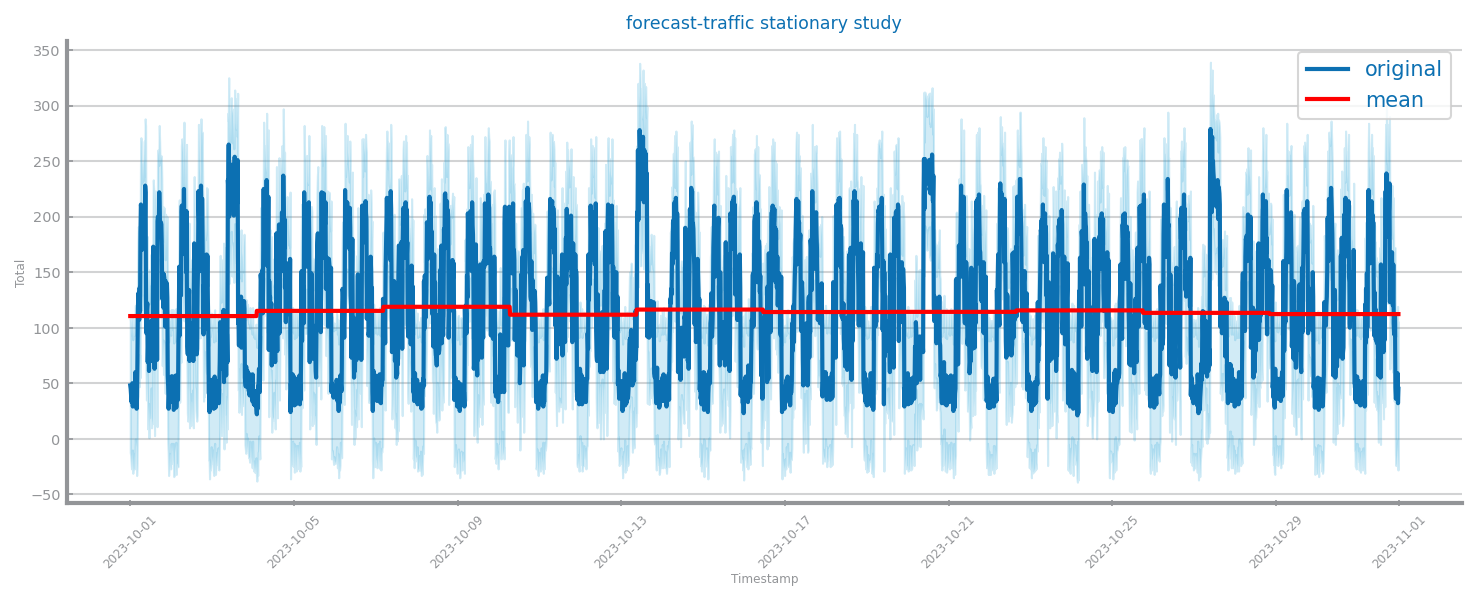

In [13]:
BINS = 10
mean_line: list[float] = []

for i in range(BINS):
    segment: Series = series[i * n // BINS : (i + 1) * n // BINS]
    mean_value: list[float] = [segment.mean()] * (n // BINS)
    mean_line += mean_value
mean_line += [mean_line[-1]] * (n - len(mean_line))

figure(figsize=(3 * HEIGHT, HEIGHT))
plot_line_chart(
    series.index.to_list(),
    series.to_list(),
    xlabel=series.index.name,
    ylabel=target,
    title=f"{file_tag} stationary study",
    name="original",
    show_stdev=True,
)
n: int = len(series)
plot(series.index, mean_line, "r-", label="mean")
legend()
savefig(f"images/forecast/{file_tag}_stationarity_mean_bins.png")
show()

In [14]:
from statsmodels.tsa.stattools import adfuller


def eval_stationarity(series: Series) -> bool:
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]:.3f}")
    print(f"p-value: {result[1]:.3f}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"\t{key}: {value:.3f}")
    return result[1] <= 0.05


print(f"The series {('is' if eval_stationarity(series) else 'is not')} stationary")

ADF Statistic: -10.044
p-value: 0.000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
The series is stationary
